In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
## getting the imports out of the way
import pandas as pd
idx = pd.IndexSlice
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget


In [3]:
experiments_and_query_lengths = {
    "404267": "2_min",
    "404268": "4_min",
    "404270": "8_min",
    "404271": "16_min",
}

In [4]:
# load all the parquet files
experiment_dfs = {}
for k,v in experiments_and_query_lengths.items():
    experiment_dfs[v] = pd.read_parquet(f"./parquets/{k}.parquet")

In [5]:
#activity colour map
colours = {
    'uncategorised': plt.cm.tab20(0),
    'sync': plt.cm.tab20(1),
    'load': plt.cm.tab20(2),
    'deserialize': plt.cm.tab20(3),
    'sensor_init': plt.cm.tab20(4),
    'net_init': plt.cm.tab20(5),
    'collect': plt.cm.tab20(6),
    'exec_tflite': plt.cm.tab20(7),
    'exec_query': plt.cm.tab20(8),
    'send': plt.cm.tab20(9),
    'save_config': plt.cm.tab20(10),
    'sleep': plt.cm.tab20(11),
    'riot_os_init': plt.cm.tab20(12),
}

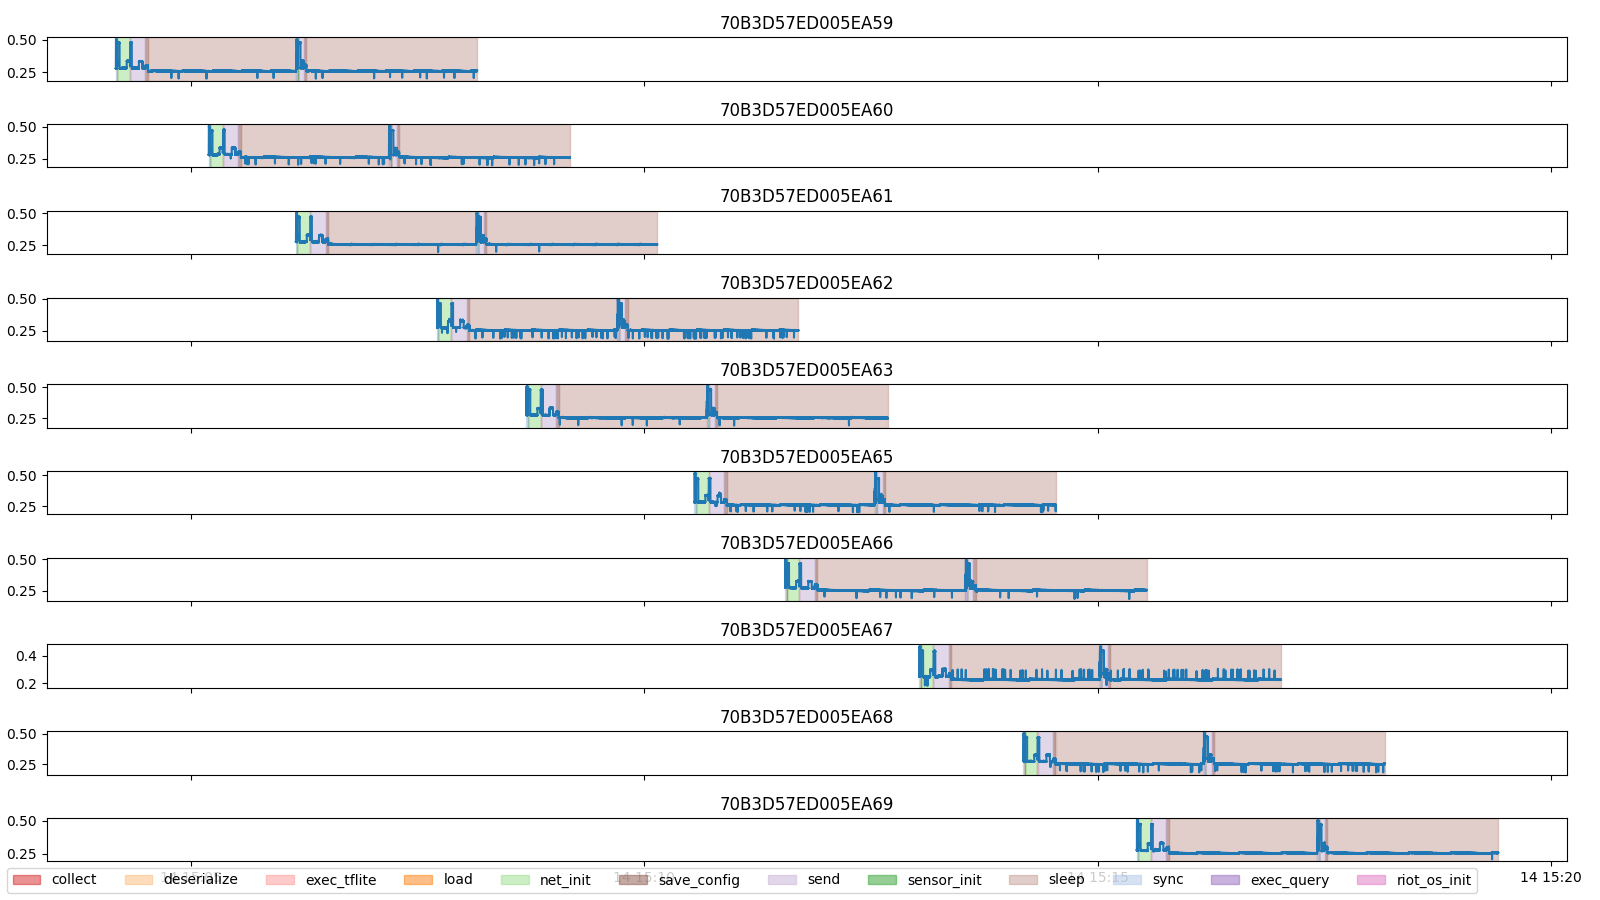

: 

In [22]:
#for fun lets plot the first loop of each node

#just for fun lets graph an example node and colour it based on activity
df =list(experiment_dfs.values())[0]
node_ids = df["node_id"].unique()

fig, axs = plt.subplots(len(node_ids), 1, figsize=(16,9), sharex=True)

for i, node_id in enumerate(node_ids):
    # select only current node_id and loop 0
    data = df[(df["node_id"] == node_id) & (df["loop_num"] <= 1.0) & (df["activity"] != "uncategorised")]
    timings = data.groupby(["loop_num", "activity"], observed=True)["timestamp"].agg(["first", "last"])
    axs[i].plot(data["timestamp"], data["power"])
    axs[i].set_title(node_id)
    for (loop, activity),v in timings.iterrows():
        axs[i].axvspan(v["first"], v["last"], alpha=0.5, color=colours[activity], label=activity)

# avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="lower left", ncol=len(by_label))
fig.tight_layout()
plt.show()


In [7]:
lel = experiment_dfs["2_min"].groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
((lel.last()-lel.first())[idx[:,:,"send"]] / np.timedelta64(1, "ms")).describe()

count      271.000000
mean      4281.385531
std       1157.932642
min       4053.119000
25%       4054.690500
50%       4055.133000
75%       4055.926500
max      10186.655000
Name: timestamp, dtype: float64

In [8]:
# lets prepare some data for plotting
data = []
averages = []
labels = []
for k,v in experiment_dfs.items():
    labels.append(k)
    group = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
    differences = (group.last() - group.first())[idx[:,:,"send"]] / np.timedelta64(1, "ms")
    averages.append(differences.mean())
    data.append(differences)

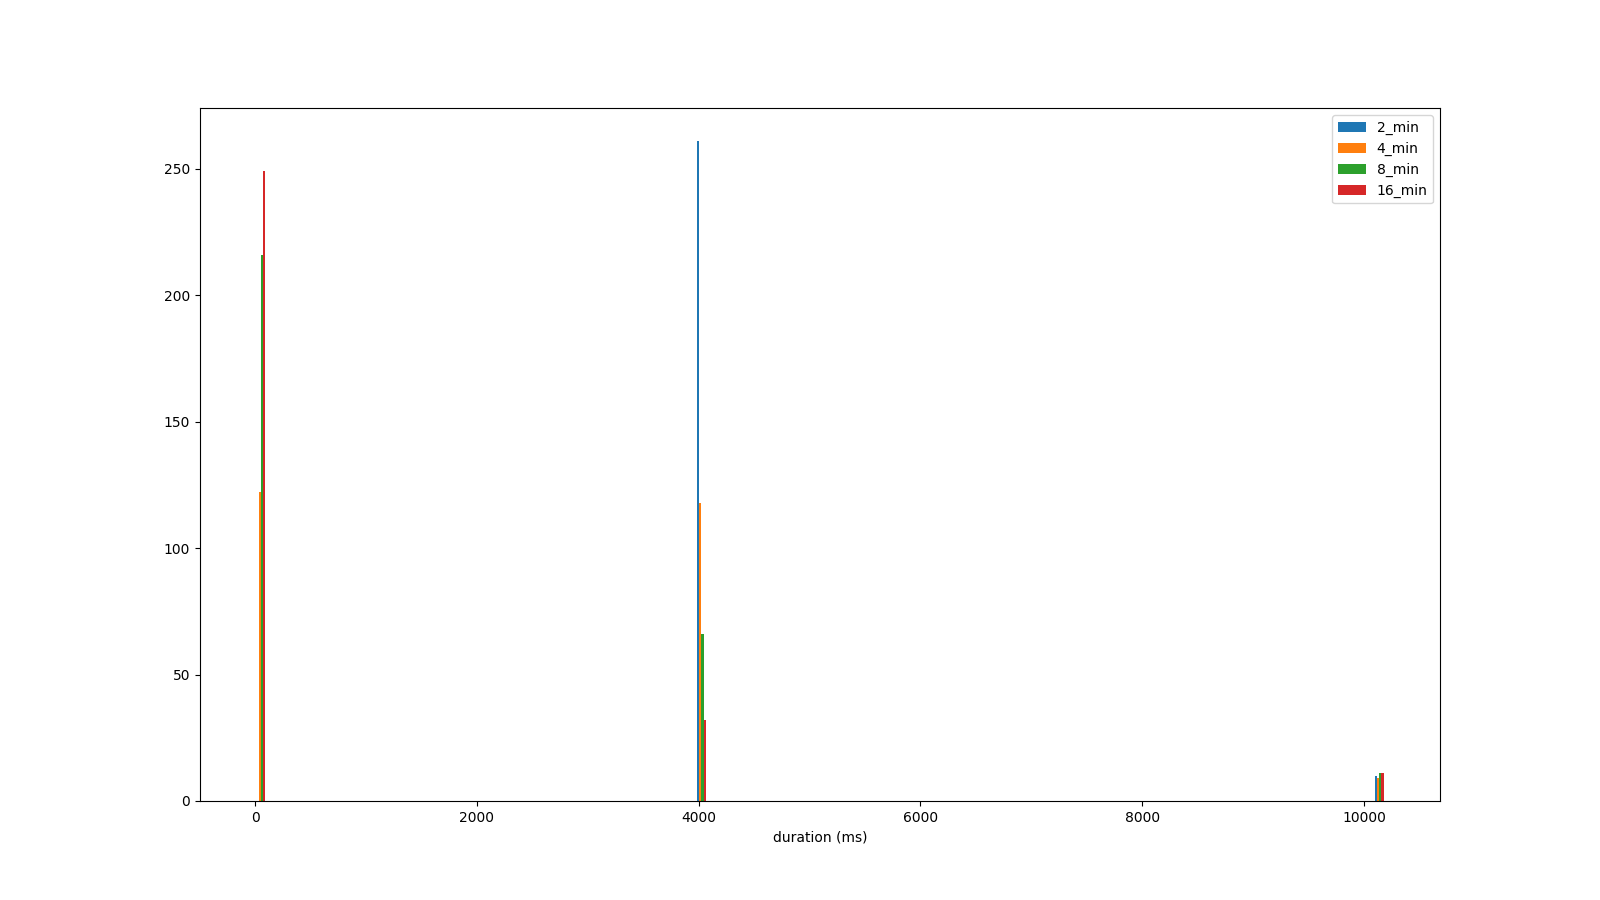

/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)


In [ ]:
plt.figure(figsize=(16,9))
plt.hist(data, label=experiment_dfs.keys(), bins=100)
plt.legend()
plt.xlabel("duration (ms)")
plt.show()

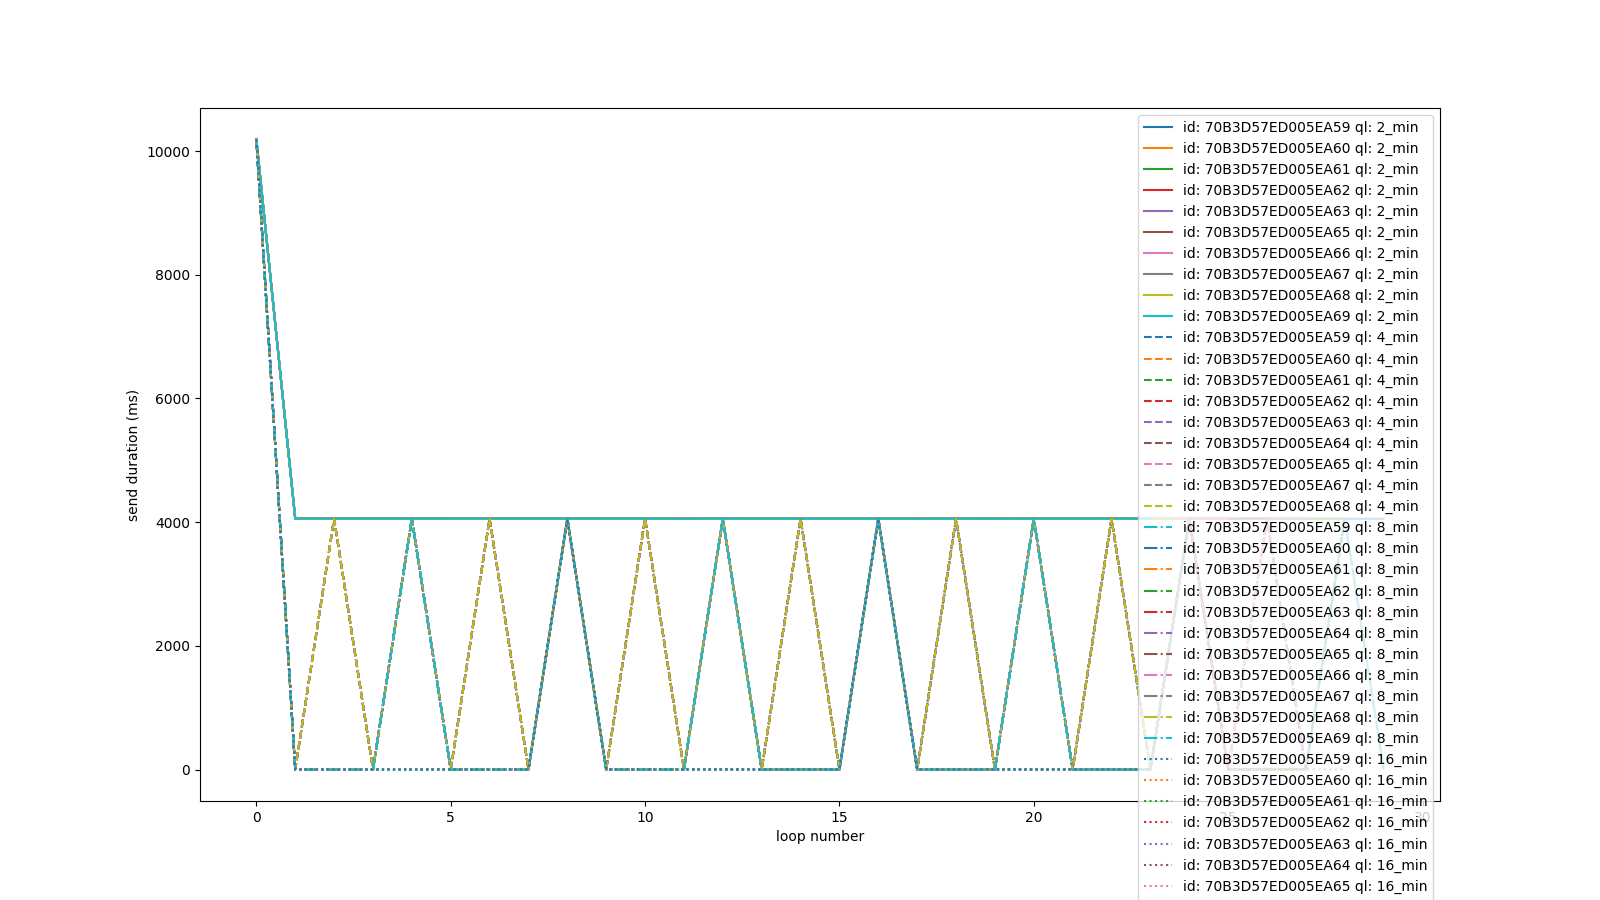

In [ ]:
# lets prepare some data for plotting
styles ={
    "2_min": "-",
    "4_min": "--",
    "8_min": "-.",
    "16_min": ":"
}
plt.figure(figsize=(16,9))
for k,v in experiment_dfs.items():
    grouper = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
    differences = (grouper.last() - grouper.first())[idx[:,:,"send"]] / np.timedelta64(1, "ms")
    for name, group in differences.groupby("node_id", observed=True):
        #print()
        plt.plot(group[idx[name,:,:]], label=f"id: {name} ql: {k}", linestyle=styles[k], )
plt.legend()
plt.xlabel("loop number")
plt.ylabel("send duration (ms)")
plt.show()

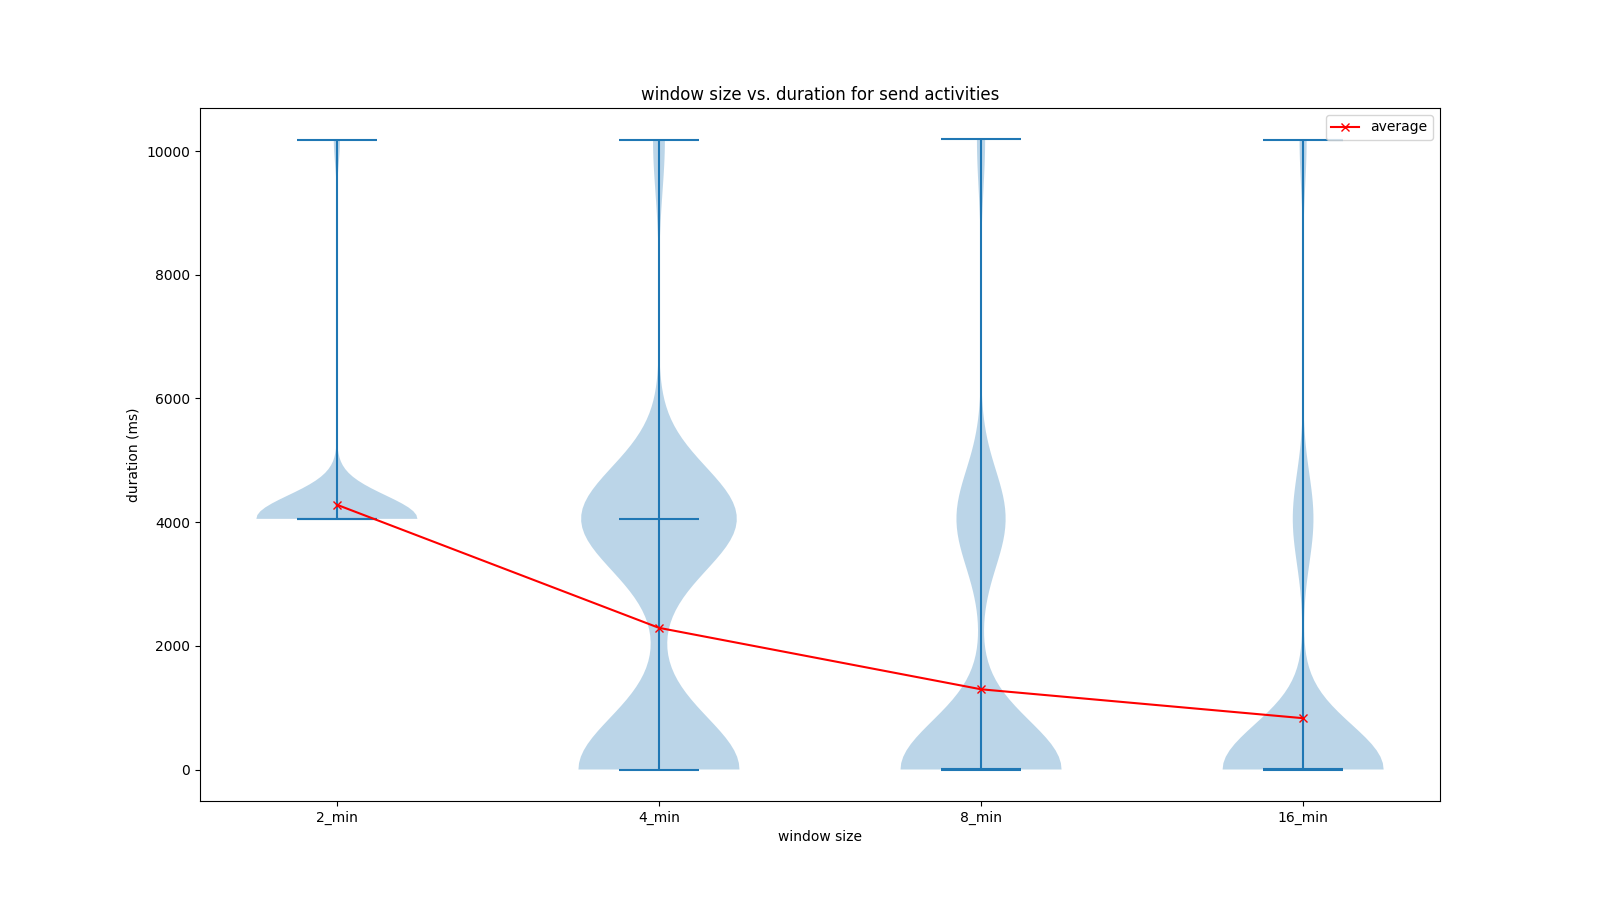

In [ ]:
# lets do a box plot of duration on serialization
plt.figure(figsize=(16,9))
plt.violinplot(data, showmedians=True)
plt.plot(np.arange(len(averages)) + 1,averages, "r-x", label="average")

plt.ylabel("duration (ms)")
plt.xlabel("window size")
plt.title("window size vs. duration for send activities")

plt.gca().set_xticks(np.arange(len(averages)) + 1,labels=labels)
plt.legend()
plt.show()

In [ ]:
# now figure out the power consumed per activity
# we do this by figuring out what the total power consumed is per node_id,loop_num,activity.
# to find that we need the time difference between each timestamp and the previous one in seconds and then multiply that with the wattage to get power consumed in WattSeconds or joule for that time slice.
# we then sum over the whole activity to get the total count of joules
for k,v in experiment_dfs.items():
    v["timestamp_diff"]  = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"].diff()
    v["joule"] = v["timestamp_diff"].dt.total_seconds() * v["power"]


In [ ]:
v.groupby(["node_id", "loop_num", "activity"], observed=True)["joule"].sum()[idx[:,:,"send"]]

node_id           loop_num
70B3D57ED005EA59  0.0         3.217804
                  1.0         0.000338
                  2.0         0.000675
                  3.0         0.000663
                  4.0         0.000334
                                ...   
70B3D57ED005EA69  19.0        0.000334
                  20.0        0.000000
                  21.0        0.000335
                  22.0        0.000000
                  23.0        0.000333
Name: joule, Length: 292, dtype: float64

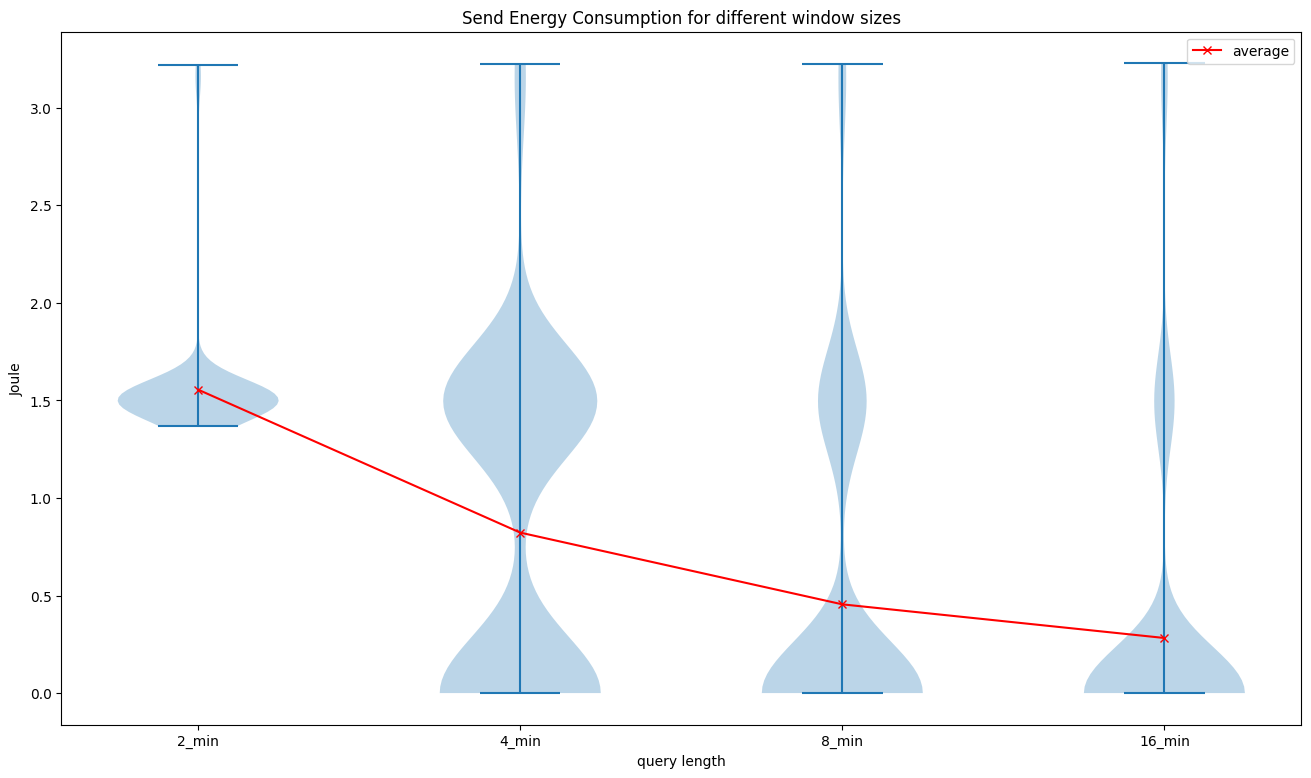

: 

In [ ]:
## lets see if we can plot the deserialization energy consumptions for the different queries
plt.figure(figsize=(16,9))
labels = []
averages = []
data = []

for k,v in experiment_dfs.items():
    d = v.groupby(["node_id", "loop_num", "activity"], observed=True)["joule"].sum()[idx[:,:,"send"]]
    data.append(d)
    averages.append(d.mean())
    labels.append(k)

plt.violinplot(data)
plt.plot(np.arange(len(averages)) + 1,averages, "r-x", label="average")
plt.ylabel("Joule")
plt.xlabel("query length")
plt.gca().set_xticks(np.arange(len(averages)) + 1,labels=labels)
plt.title("Send Energy Consumption for different window sizes")
plt.legend()
plt.show()
